# Motivation
The motivation behind this notebook is to build a `denoising autoencoder`. The following things are to be kept in mind.
1. Dataset used is `ImageNet Subset`.
2. The t-SNE of the embeddings are analysed.
3. The latent space is clustered into `64 clusters`. (equisized would be great)


# Imports
The packages used are:
1. tensorflow
2. `tf.keras`
3. numpy
4. matplotlip
5. sklearn
6. scipy
7. random
8. imutils
9. tqdm

In [ ]:
! nvidia-smi

Fri Oct  2 06:22:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
! pip install wandb
import wandb
from wandb.keras import WandbCallback

In [ ]:
! wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(entity="g-simclr", project="g-simclr", id="imgNet-subset-autoenc-deep")

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.model_selection import train_test_split

from scipy.special import comb

import random
from imutils import paths
from tqdm import tqdm

# Dataset gathering and preparation
* Using `ImageNetSubset` which consists of 5 categories.
* Builing a `tf.data.Dataset` of the images.
* We need to pre-process the data before loading.

The dataset comes in the train and test folders. For the autoencoder we are going use the `train` only and keep the `test` folder as in to prevent data leakage in the further evaluation steps.

In [ ]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into '/content/drive/My Drive/Data'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 23.25 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (1501/1501), done.


In [ ]:
# Train image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
print('Info: # of train images: {}'.format(len(train_images)))

# Test image paths
test_images = list(paths.list_images("imagenet-5-categories/test"))
print('Info: # of test images: {}'.format(len(test_images)))

Info: # of train images: 1250
Info: # of test images: 250


In [ ]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image, image

In [ ]:
# Create TensorFlow dataset.
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices(test_images)
test_ds = (
    test_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Autoencoder

In [ ]:
def make_autoencoder(inputs):
  # 224,224,3
  # Provide the noise
  x = tf.keras.layers.GaussianNoise(stddev=1e-2)(inputs)
  x = tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D()(x)
  # 112,112,64 
  x = tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D()(x)
  # 56,56,128
  x = tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D()(x)
  # 28,28,256
  x = tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D()(x)
  # 14,14,512
  x = tf.keras.layers.Conv2D(filters=1024,kernel_size=(5,5),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D(name='retrieval')(x)
  # 7,7,1024
  x = tf.keras.layers.UpSampling2D()(x)
  # 14,14,1024
  x = tf.keras.layers.Conv2D(filters=1024,kernel_size=(5,5),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.UpSampling2D()(x)
  # 28,28,1024
  x = tf.keras.layers.Conv2D(filters=512,kernel_size=(5,5),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.UpSampling2D()(x)
  # 56,56,512
  x = tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.UpSampling2D()(x)
  # 112,112,256
  x = tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.UpSampling2D()(x)
  # 224,224,128
  x = tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  # 224,224,64
  x = tf.keras.layers.Conv2D(filters=3,kernel_size=(5,5),activation='sigmoid',padding='same')(x)

  return x

## Training

In [ ]:
# # Relu
# relu_variation = tf.keras.layers.ReLU(threshold=25/65025.)
# def my_loss(y_true, y_pred):
#   # (N, H,W,C)
#   squared_diff = tf.math.square(y_true - y_pred)
#   squared_diff_relu = relu_variation(squared_diff)
#   app_exact_match = tf.math.reduce_mean(squared_diff_relu, axis=-1)
#   return app_exact_match

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(224,224,3))
outputs = make_autoencoder(inputs)

model = tf.keras.Model(
		inputs=inputs,
		outputs=outputs,
		name="autoencoder"
		)
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='mse')
model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=2, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=100,
    callbacks=[es,WandbCallback()]
    )

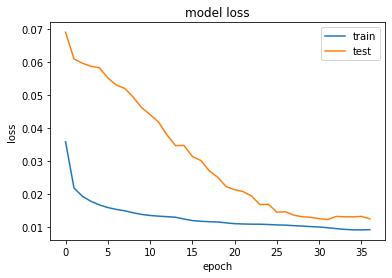

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
loss = model.evaluate(test_ds)
print('INFO: loss on test: {:.4f}'.format(loss))

3/3 [==============================] - 2s 556ms/step - loss: 0.0122
INFO: loss on test: 0.0122


### Store the model

In [ ]:
from google.colab import drive
import datetime
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "autoencoder_imagenet.h5"
filename
model.save('/content/drive/My Drive/Colab Notebooks/Souradip Sayak/SimCLR_Imagenet_Subset/Pretrained_Weights/{}'.format(filename))

## Evaluation
Let's see the reconstruction the model provides on the unseen test-set

In [ ]:
import cv2

In [ ]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [ ]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)
print('INFO: X_train: {}'.format(X_train.shape))
print('INFO: y_train: {}'.format(y_train.shape))
print('INFO: X_test: {}'.format(X_test.shape))
print('INFO: y_test: {}'.format(y_test.shape))

 10%|█         | 25/250 [00:00<00:00, 240.56it/s]

(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 229.40it/s]


(250, 224, 224, 3) (250,)
INFO: X_train: (1250, 224, 224, 3)
INFO: y_train: (1250,)
INFO: X_test: (250, 224, 224, 3)
INFO: y_test: (250,)


In [ ]:
# Taking 5 images from the test dataset for reconstruction
img = X_test[:5].copy()
rec = model.predict(img)
img.shape, rec.shape

((5, 224, 224, 3), (5, 224, 224, 3))

Test Images


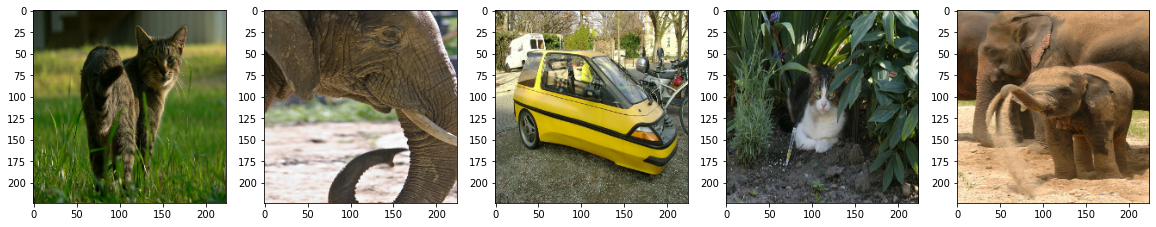

Reconstruction of Test Images


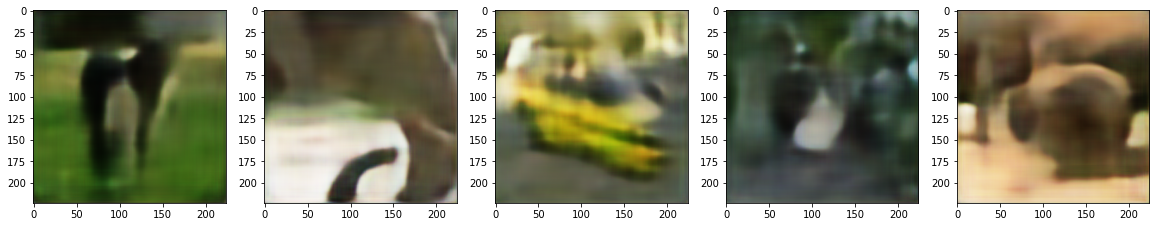

In [ ]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(img[i])
plt.show() 

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(rec[i])
plt.show()

# Retrieval
This section of the code extracts the embeddings. The embeddings are later used to cluster together to present the t-SNE. The 

In [ ]:
layer_name = 'retrieval'
slice_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output
    )
slice_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)    

In [ ]:
latent_train = slice_model.predict(X_train)
latent_test = slice_model.predict(X_test)
latent_train.shape, latent_test.shape

((1250, 7, 7, 1024), (250, 7, 7, 1024))

In [ ]:
embedding_train = tf.keras.layers.GlobalAveragePooling2D()(latent_train)
embedding_test = tf.keras.layers.GlobalAveragePooling2D()(latent_test)
embedding_train.shape, embedding_test.shape

(TensorShape([1250, 1024]), TensorShape([250, 1024]))

## t-SNE of the latent space
Here we observe the embeddings. This would be a good place to see what is happening in the autoencoder. This would also provide us with the intuitions of clusters.

In [ ]:
tsne_train = TSNE(n_components=2).fit_transform(embedding_train)
tsne_test = TSNE(n_components=2).fit_transform(embedding_test)
tsne_train.shape, tsne_test.shape

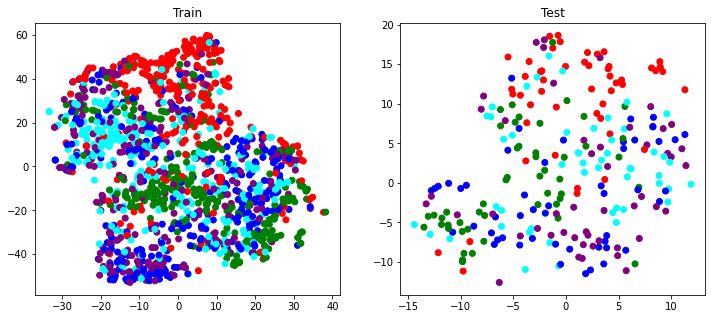

In [ ]:
colors = ['red','green','blue','purple','cyan']
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(tsne_train[:,0],tsne_train[:,1],c=y_train_enc, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Train')
plt.subplot(1,2,2)
plt.scatter(tsne_test[:,0],tsne_test[:,1],c=y_test_enc, cmap=matplotlib.colors.ListedColormap(colors))
plt.title('Test')
plt.show()

## Cluster the train latent

In [ ]:
BATCH_SIZE = 64
classifier = KMeans(n_clusters=BATCH_SIZE, random_state=0).fit(embedding_train)
# labels of the clusters
labels = classifier.labels_
labels.shape

(1250,)

## Ordering the data


In [ ]:
import pandas as pd

In [ ]:
# Building the DataFrame
df = pd.DataFrame()
df['cluster_labels'] = labels
df['imag_ind'] = np.arange(0,len(df))
df = df[['imag_ind','cluster_labels']]
df.head()

,imag_ind,cluster_labels
0,0,19
1,1,3
2,2,52
3,3,6
4,4,38


In [ ]:
# The rank according to the cluster_labels
df["rank"] = df.groupby("cluster_labels")["imag_ind"].rank("dense", ascending=True)
df.head()

,imag_ind,cluster_labels,rank
0,0,19,1.0
1,1,3,1.0
2,2,52,1.0
3,3,6,1.0
4,4,38,1.0


In [ ]:
# Sorting the labels by cluster_labels and rank
df_data = df.sort_values(by = ['cluster_labels','rank'])
df_data.head()

,imag_ind,cluster_labels,rank
36,36,0,1.0
46,46,0,2.0
146,146,0,3.0
165,165,0,4.0
240,240,0,5.0


In [ ]:
# Sort with respect to rank only
df_data2 = df_data.sort_values(by = ['rank'])
df_data2.head()

,imag_ind,cluster_labels,rank
36,36,0,1.0
61,61,15,1.0
99,99,47,1.0
11,11,48,1.0
47,47,14,1.0


In [ ]:
arr_ind = df_data2['imag_ind'].values
X_new = X_train[arr_ind]

In [ ]:
X_new.shape

(1250, 224, 224, 3)

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Souradip Sayak/SimCLR_Imagenet_Subset/Pretrained_Weights/X_new.npy'
with open(path, 'wb') as f:
  np.save(f, X_new)